# CARREGAR A BASE DE DADOS (ARQUIVOS NPY)

                     filename  \
0  SBBE_2015-08-08_E6_100.png   
1  SBBE_2015-08-08_E6_110.png   
2  SBBE_2015-08-08_E6_120.png   
3  SBBE_2015-08-08_E6_130.png   
4  SBBE_2015-08-08_E6_140.png   

                                               image  clusters  
0  [[[0.3764705882352941, 0.42745098039215684, 0....         3  
1  [[[0.19607843137254902, 0.24313725490196078, 0...         3  
2  [[[0.3568627450980392, 0.38823529411764707, 0....         3  
3  [[[0.28627450980392155, 0.34509803921568627, 0...         3  
4  [[[0.2823529411764706, 0.30980392156862746, 0....         3  


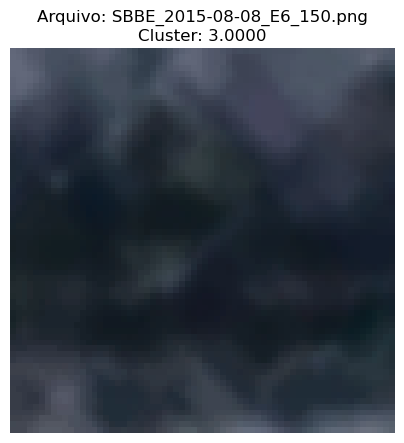

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Caminho para os arquivos .npy
images_file_path = r'C:\Users\silve\TESE\images_by_cluster_80.npy'
coefs_file_path = r'C:\Users\silve\TESE\clusters_80.npy'
filenames_file_path = r'C:\Users\silve\TESE\filenames_80.npy'  # Caminho para o arquivo com os nomes dos arquivos

# Carregar os arrays numpy dos arquivos .npy
images_array = np.load(images_file_path, allow_pickle=True)
coefs_array = np.load(coefs_file_path, allow_pickle=True)
filenames_array = np.load(filenames_file_path, allow_pickle=True)  # Carregar o array com os nomes dos arquivos

# Reconstruir o DataFrame incluindo a coluna de nomes de arquivos
df_images = pd.DataFrame({
    'filename': filenames_array,  # Adicionar os nomes dos arquivos como uma nova coluna
    'image': list(images_array),  # Converter o array de imagens para uma lista de arrays
    'clusters': coefs_array
})

# Exibir as primeiras linhas do DataFrame para confirmar a estrutura
print(df_images.head())

# Função para exibir uma imagem do DataFrame, seu coeficiente e o nome do arquivo
def display_image_and_cluster(df, index):
    # Verificar se o índice é válido
    if index < 0 or index >= len(df):
        print("Índice fora do intervalo.")
        return

    # Acessar a imagem, o coeficiente e o nome do arquivo
    image_array = df.at[index, 'image']
    cluster = df.at[index, 'clusters']
    filename = df.at[index, 'filename']

    # Configurar a figura
    plt.figure(figsize=(5, 5))

    # Exibir a imagem
    plt.imshow(image_array)
    plt.axis('off')  # Desligar os eixos para uma visualização mais clara

    # Exibir o coeficiente de cluster e o nome do arquivo como título
    plt.title(f'Arquivo: {filename}\nCluster: {cluster:.4f}', fontsize=12)

    # Mostrar a figura
    plt.show()

# Exemplo de uso da função para exibir a imagem no índice 5, seu coeficiente e o nome do arquivo
display_image_and_cluster(df_images, 5)


# CRIAÇÃO DOS GRUPOS DE TREINO, VALIDAÇÃO E TESTE

In [2]:
from sklearn.model_selection import train_test_split

# Dividir o DataFrame em conjunto de treino e teste
train_df, test_df = train_test_split(df_images, test_size=0.2, random_state=42)

# Dividir o conjunto de treino para criar o conjunto de validação
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

print(f'Tamanho do conjunto de treino: {len(train_df)}')
print(f'Tamanho do conjunto de validação: {len(val_df)}')
print(f'Tamanho do conjunto de teste: {len(test_df)}')

# Função para preparar os dados, incluindo os filenames
def prepare_data(df):
    """Extrai imagens, clusters e filenames do DataFrame e os converte em arrays numpy."""
    images = np.array(list(df['image']))  # Listar e converter para array numpy
    clusters = np.array(df['clusters'])
    filenames = df['filename'].to_numpy()  # Converter a coluna de filenames para array numpy
    return images, clusters, filenames

# Preparar os dados para treino, validação e teste
X_train, y_train, filenames_train = prepare_data(train_df)
X_val, y_val, filenames_val = prepare_data(val_df)
X_test, y_test, filenames_test = prepare_data(test_df)

print(f'Forma das imagens de treino: {X_train.shape}')
print(f'Forma dos clusters de treino: {y_train.shape}')
print(f'Forma dos filenames de treino: {filenames_train.shape}')
print(f'Forma das imagens de validação: {X_val.shape}')
print(f'Forma dos clusters de validação: {y_val.shape}')
print(f'Forma dos filenames de validação: {filenames_val.shape}')
print(f'Forma das imagens de teste: {X_test.shape}')
print(f'Forma dos clusters de teste: {y_test.shape}')
print(f'Forma dos filenames de teste: {filenames_test.shape}')


Tamanho do conjunto de treino: 16425
Tamanho do conjunto de validação: 5476
Tamanho do conjunto de teste: 5476
Forma das imagens de treino: (16425, 66, 66, 3)
Forma dos clusters de treino: (16425,)
Forma dos filenames de treino: (16425,)
Forma das imagens de validação: (5476, 66, 66, 3)
Forma dos clusters de validação: (5476,)
Forma dos filenames de validação: (5476,)
Forma das imagens de teste: (5476, 66, 66, 3)
Forma dos clusters de teste: (5476,)
Forma dos filenames de teste: (5476,)


# PROCESSAMENTO DO MODELO

## OTIMIZAÇÃO DOS HIPERPARÂMETROS

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch
import os
import shutil

def build_model(hp):
    base_model = ResNet50(include_top=False, input_shape=(66, 66, 3), weights='imagenet')
    base_model.trainable = False  # Congelar as camadas da ResNet50

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(units=hp.Int('dense_units', min_value=128, max_value=1024, step=128), activation='relu'),
        Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)),
        Dense(len(np.unique(y_train)), activation='softmax')  # Ajuste para o número de classes
    ])

    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Caminho para o diretório do Keras Tuner
tuner_dir = '11_resnet50_80'

# Prompt para o usuário
reset = input("Deseja resetar as informações da última rodada e iniciar uma nova otimização? (s/n): ")

if reset.lower() == 's':
    if os.path.exists(tuner_dir):
        shutil.rmtree(tuner_dir)  # Remove o diretório e todo o seu conteúdo
        print("Informações da última rodada resetadas. Iniciando nova otimização...")
    else:
        print("Nenhum dado de rodada anterior encontrado. Iniciando nova otimização...")

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=12,
    executions_per_trial=1,
    directory=tuner_dir,
    project_name='resnet50_hyperparam_optimization'
)

if reset.lower() == 'n':
    # Carrega os melhores hiperparâmetros da última otimização
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    # Constrói o modelo com os melhores hiperparâmetros
    model = build_model(best_hps)
    print("Modelo carregado com os melhores hiperparâmetros da última otimização.")

# Continua para treino, validação e teste com `model`
# model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=...)



Deseja resetar as informações da última rodada e iniciar uma nova otimização? (s/n): n
Reloading Tuner from 11_resnet50_80\resnet50_hyperparam_optimization\tuner0.json


Modelo carregado com os melhores hiperparâmetros da última otimização.


## RODANDO O MODELO DE ACORDO COM OS HIPERPARÂMETROS OTIMIZADOS

In [4]:
# Obtenha os melhores hiperparâmetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Construa o modelo com os melhores hiperparâmetros
model = build_model(best_hps)

# Exibir a arquitetura do modelo
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 384)               786816    
                                                                 
 dropout_1 (Dropout)         (None, 384)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1540      
                                                                 
Total params: 24376068 (92.99 MB)
Trainable params: 788356 (3.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Definindo a seed
np.random.seed(42)
tf.random.set_seed(42)

# Supondo que a função build_model e o objeto tuner já estejam definidos como anteriormente

# Obtenha os melhores hiperparâmetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Construa o modelo com os melhores hiperparâmetros
model = build_model(best_hps)

# Após construir o modelo, opcionalmente, desbloqueie algumas das últimas camadas para ajuste fino
for layer in model.layers:
    # Verifica se a camada é uma instância do modelo base (ResNet50)
    if isinstance(layer, tf.keras.Model):
        # Desbloqueia as últimas N camadas do modelo base
        for sub_layer in layer.layers[-5:]:  # Exemplo: Desbloqueia as últimas 5 camadas
            sub_layer.trainable = True

# Compile o modelo novamente após o desbloqueio das camadas, se o ajuste fino for realizado
model.compile(optimizer=Adam(learning_rate=1e-5),  # Use uma taxa de aprendizado menor para ajuste fino
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Defina o callback de Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitora a perda de validação
    patience=30,         # Número de épocas sem melhoria após o qual o treinamento será interrompido
    restore_best_weights=True  # Restaura os pesos do modelo com o melhor valor de perda de validação
)

# Certifique-se de que X_train, y_train, X_val, e y_val estão definidos e prontos para uso

# Treine o modelo com Early Stopping
history = model.fit(
    X_train, y_train,
    epochs=150,  # Número máximo de épocas
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]  # Inclui o callback de Early Stopping
)

# Certifique-se de que X_test e y_test estão definidos e prontos para uso

# Opcional: Avalie o modelo no conjunto de teste após o treinamento
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Perda no teste: {test_loss}, Acurácia no teste: {test_accuracy}")


Epoch 1/150


514/514 [==============================] - 74s 139ms/step - loss: 1.3856 - accuracy: 0.2705 - val_loss: 1.3838 - val_accuracy: 0.2650
Epoch 2/150
514/514 [==============================] - 71s 139ms/step - loss: 1.3845 - accuracy: 0.2729 - val_loss: 1.3829 - val_accuracy: 0.2752
Epoch 3/150
514/514 [==============================] - 73s 143ms/step - loss: 1.3847 - accuracy: 0.2735 - val_loss: 1.3822 - val_accuracy: 0.2752
Epoch 4/150
514/514 [==============================] - 67s 131ms/step - loss: 1.3843 - accuracy: 0.2743 - val_loss: 1.3871 - val_accuracy: 0.2752
Epoch 5/150
514/514 [==============================] - 74s 145ms/step - loss: 1.3843 - accuracy: 0.2718 - val_loss: 1.3819 - val_accuracy: 0.2750
Epoch 6/150
514/514 [==============================] - 75s 145ms/step - loss: 1.3844 - accuracy: 0.2736 - val_loss: 1.3819 - val_accuracy: 0.2783
Epoch 7/150
514/514 [==============================] - 70s 137ms/step - loss: 1.3836 - accuracy: 0.2748 - val_loss: 1.3821

Epoch 54/150
514/514 [==============================] - 61s 118ms/step - loss: 1.3777 - accuracy: 0.2813 - val_loss: 1.3773 - val_accuracy: 0.2812
Epoch 55/150
514/514 [==============================] - 61s 118ms/step - loss: 1.3780 - accuracy: 0.2840 - val_loss: 1.3786 - val_accuracy: 0.2873
Epoch 56/150
514/514 [==============================] - 61s 118ms/step - loss: 1.3777 - accuracy: 0.2863 - val_loss: 1.3804 - val_accuracy: 0.2840
Epoch 57/150
514/514 [==============================] - 61s 118ms/step - loss: 1.3784 - accuracy: 0.2876 - val_loss: 1.3797 - val_accuracy: 0.2799
Epoch 58/150
514/514 [==============================] - 61s 118ms/step - loss: 1.3773 - accuracy: 0.2865 - val_loss: 1.3769 - val_accuracy: 0.2834
Epoch 59/150
514/514 [==============================] - 61s 118ms/step - loss: 1.3777 - accuracy: 0.2867 - val_loss: 1.3773 - val_accuracy: 0.2856
Epoch 60/150
514/514 [==============================] - 61s 118ms/step - loss: 1.3775 - accuracy: 0.2846 - val_loss: 1

514/514 [==============================] - 67s 130ms/step - loss: 1.3750 - accuracy: 0.2877 - val_loss: 1.3758 - val_accuracy: 0.2891
Epoch 110/150
514/514 [==============================] - 72s 140ms/step - loss: 1.3748 - accuracy: 0.2902 - val_loss: 1.3760 - val_accuracy: 0.2907
Epoch 111/150
514/514 [==============================] - 72s 139ms/step - loss: 1.3747 - accuracy: 0.2890 - val_loss: 1.3770 - val_accuracy: 0.2925
Epoch 112/150
514/514 [==============================] - 63s 123ms/step - loss: 1.3743 - accuracy: 0.2886 - val_loss: 1.3753 - val_accuracy: 0.2929
Epoch 113/150
514/514 [==============================] - 63s 123ms/step - loss: 1.3743 - accuracy: 0.2951 - val_loss: 1.3753 - val_accuracy: 0.2876
Epoch 114/150
514/514 [==============================] - 63s 123ms/step - loss: 1.3747 - accuracy: 0.2905 - val_loss: 1.3774 - val_accuracy: 0.2883
Epoch 115/150
514/514 [==============================] - 63s 122ms/step - loss: 1.3742 - accuracy: 0.2908 - val_loss: 1.3809 -

## INDICADORES DE PERFORMANCE DO MODELO

### PARÂMETROS NUMÉRICOS NO TESTE (PERDA, ACURÁCIA, PRECISÃO, RECALL E F1)

In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Avaliar o modelo no conjunto de validação
test_loss, test_acc = model.evaluate(X_val, y_val, verbose=2)

# Previsões do modelo
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Verificar se y_val é categórico e converter para classes se necessário
if y_val.ndim > 1:
    y_true = np.argmax(y_val, axis=1)
else:
    y_true = y_val

# Matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Acurácia
accuracy = accuracy_score(y_true, y_pred_classes)

# Precisão, Recall e F1 Score com tratamento para problemas multiclasse
precision = precision_score(y_true, y_pred_classes, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred_classes, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred_classes, average='macro', zero_division=0)

# Imprimir os resultados
print(f"Perda na Validação: {test_loss}")
print(f"Acurácia na Validação: {test_acc}")
print("Matriz de Confusão:", conf_matrix, sep="\n")
print(f"Precisão: {precision}")
print(f"Recall: {recall}")
print(f"Pontuação F1: {f1}")


172/172 - 15s - loss: 1.3752 - accuracy: 0.2852 - 15s/epoch - 86ms/step
172/172 [==============================] - 16s 87ms/step
Perda na Validação: 1.3752021789550781
Acurácia na Validação: 0.2852447032928467
Matriz de Confusão:
[[ 104 1245   73   13]
 [  85 1329   75   18]
 [  77 1009  117   11]
 [  91 1119   98   12]]
Precisão: 0.27962462027696533
Recall: 0.26495623332449875
Pontuação F1: 0.17750248554141645


### CURVA DE APRENDIZADO PERDA E ACURÁCIA

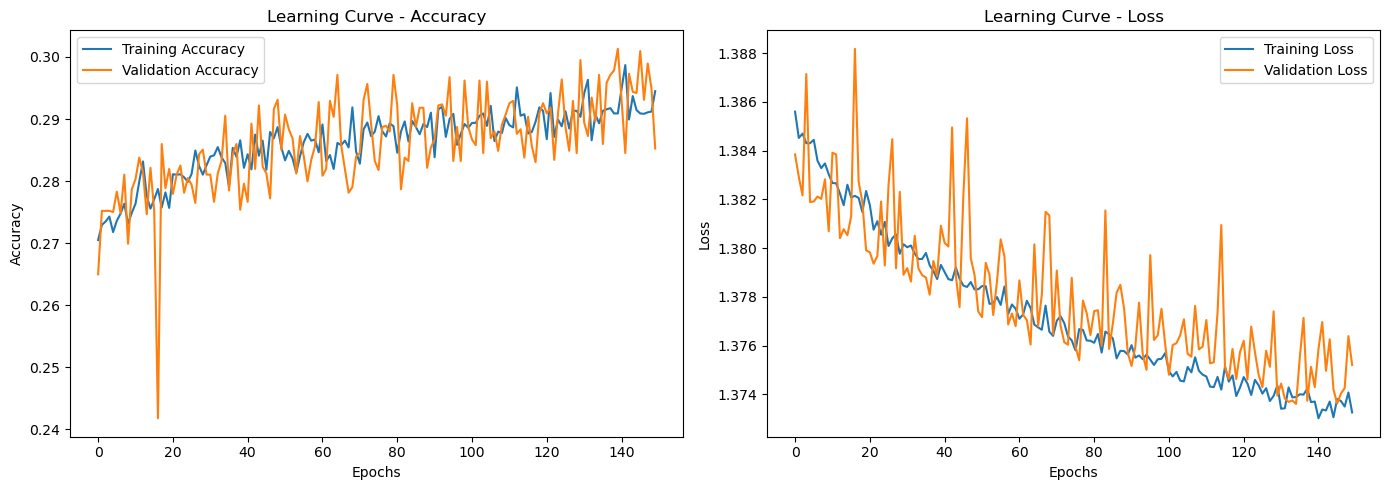

In [7]:
import matplotlib.pyplot as plt

# Plotting the learning curves
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Learning Curve - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### MATRIZ DE CONFUSÃO

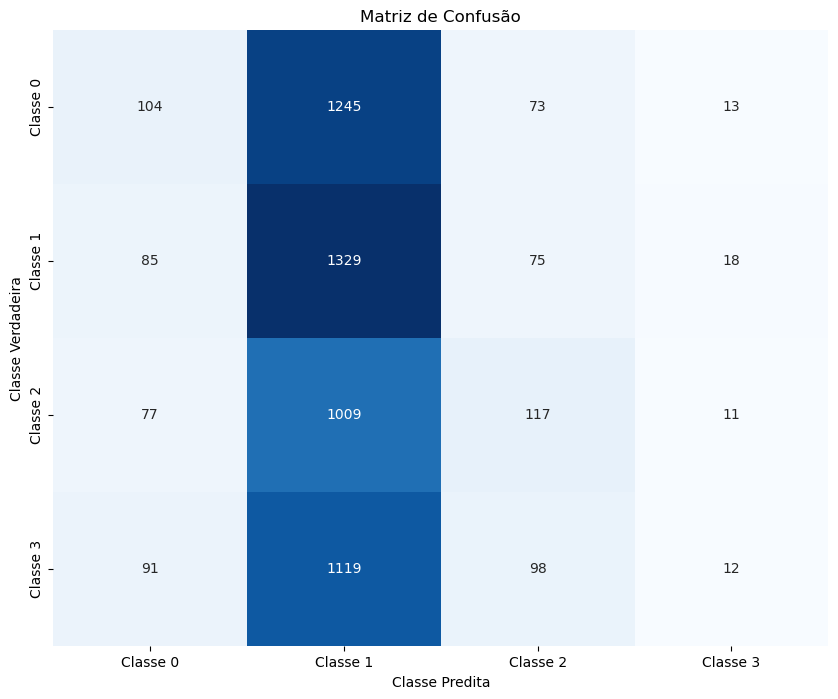

In [8]:
# MATRIZ DE CONFUSÃO

# Primeiro, instale as bibliotecas necessárias se ainda não estiverem instaladas:
# !pip install matplotlib seaborn numpy

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Insira seus dados de Matriz de Confusão aqui
confusion_mtx = conf_matrix

# Etiquetas para os eixos
axis_labels = ['Classe 0', 'Classe 1', 'Classe 2', 'Classe 3']

# Configurando o tamanho da figura
plt.figure(figsize=(10, 8))

# Criando o heatmap
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap="Blues", cbar=False, xticklabels=axis_labels, yticklabels=axis_labels)

# Adicionando o título e os rótulos dos eixos
plt.title('Matriz de Confusão')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Predita')

# Mostrando o gráfico
plt.show()


172/172 [==============================] - 15s 86ms/step


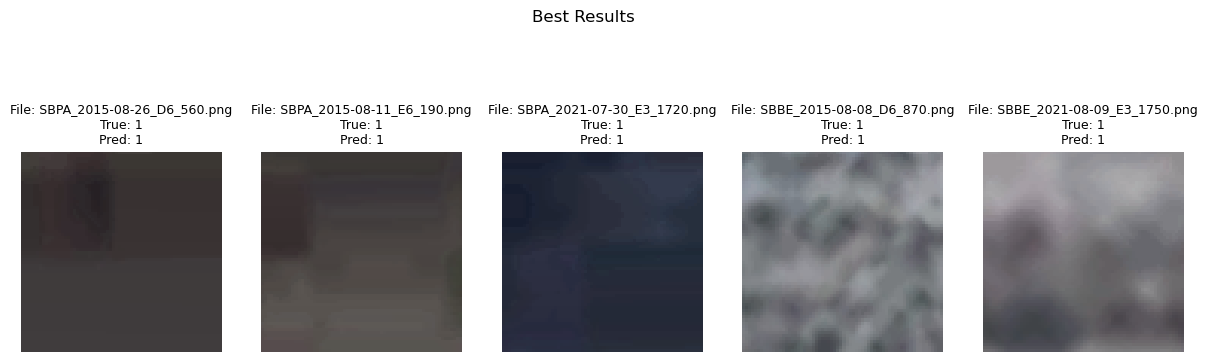

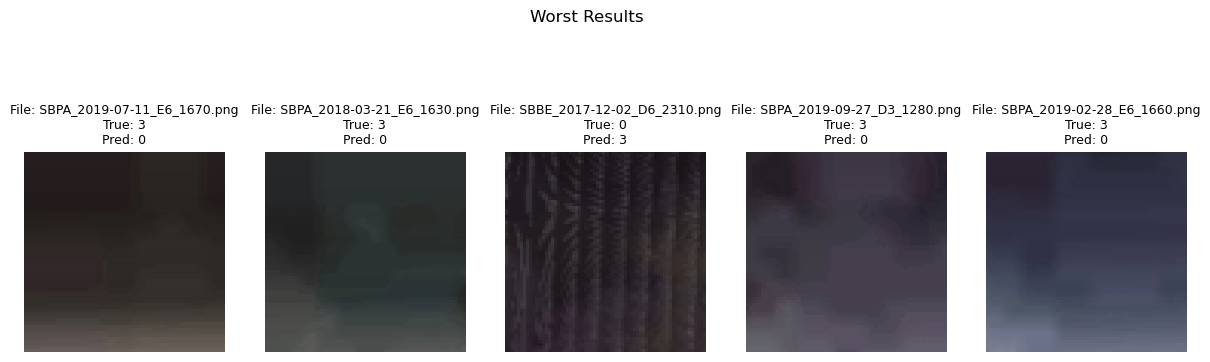

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Use the model to predict the classes of the test images
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Calculate individual losses using absolute difference
losses = np.abs(y_test - y_pred_classes)

# Sort the losses and get the indices of the best and worst predictions
sorted_indices = np.argsort(losses)
best_indices = sorted_indices[:5]  # Indices of the 5 best predictions
worst_indices = sorted_indices[-5:]  # Indices of the 5 worst predictions

# Access the filenames for the best and worst predictions using the indices
best_filenames = filenames_test[best_indices]
worst_filenames = filenames_test[worst_indices]

def plot_results(indices, images, true_labels, pred_labels, filenames, title):
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[idx].squeeze(), cmap='gray')  # Adjust as necessary
        # Fixed: Use 'i' to access 'filenames', but 'idx' for the other arrays
        plt.title(f"File: {filenames[i]}\nTrue: {true_labels[idx]}\nPred: {pred_labels[idx]}", fontsize=9)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()


# Plot the five best predictions with the correct filenames
plot_results(best_indices, X_test, y_test, y_pred_classes, best_filenames, "Best Results")

# Plot the five worst predictions with the correct filenames
plot_results(worst_indices, X_test, y_test, y_pred_classes, worst_filenames, "Worst Results")


172/172 [==============================] - 15s 87ms/step


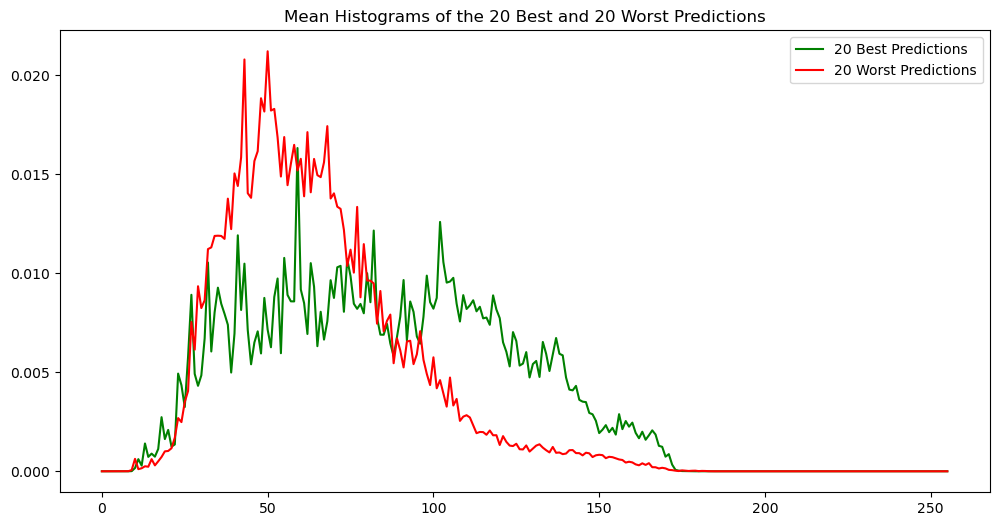

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Assumindo que 'best_model' é o seu modelo treinado, 'X_test' é o seu conjunto de teste,
# e 'y_test' são os rótulos verdadeiros.

# Realizar previsões no conjunto de teste
y_pred = model.predict(X_test)

# Converter as previsões de probabilidades para rótulos de classe
y_pred_classes = np.argmax(y_pred, axis=1)

# Calcular a "perda" como a diferença entre os rótulos verdadeiros e previstos
losses = np.abs(y_test - y_pred_classes)

# Ordenar as perdas e identificar os índices das 20 melhores e 20 piores previsões
sorted_indices = np.argsort(losses)
best_indices = sorted_indices[:20]
worst_indices = sorted_indices[-20:]

def calculate_mean_histogram(images):
    histograms = [np.histogram(image.ravel(), bins=256, range=(0, 1))[0] for image in images]
    mean_histogram = np.mean(histograms, axis=0)
    return mean_histogram / mean_histogram.sum()  # Normalizar o histograma

# Selecionar as 20 melhores e 20 piores imagens com base nos índices identificados
best_images = X_test[best_indices]
worst_images = X_test[worst_indices]

# Calcular os histogramas médios para os dois conjuntos de imagens
mean_histogram_best = calculate_mean_histogram(best_images)
mean_histogram_worst = calculate_mean_histogram(worst_images)

# Plotar os histogramas médios no mesmo gráfico
plt.figure(figsize=(12, 6))
plt.plot(mean_histogram_best, color='green', label='20 Best Predictions')
plt.plot(mean_histogram_worst, color='red', label='20 Worst Predictions')
plt.title('Mean Histograms of the 20 Best and 20 Worst Predictions')
plt.legend()
plt.show()


## SALVANDO O MODELO

In [12]:
# Salvar o modelo no formato HDF5
model.save('meu_modelo_80_RESNET50.h5')

# Salvar o modelo no formato SavedModel
model.save('meu_modelo_80_RESNET50')


C:\Users\silve\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: meu_modelo_80_RESNET50\assets


INFO:tensorflow:Assets written to: meu_modelo_80_RESNET50\assets
